### George Verghese WXY Urban Data Analyst
### Test Notebook
To take a test, please clone the relevant branch and send us back a repo with a completed notebook! 

Geospatial Python Test  
Please analyze and visualize Active Major Construction permits in New York City in a jupyter notebook (New Building or Major Alteration A1). The data can be downloaded here.   


At a minimum:   

Create a summary table with key metrics     
Visually explore key metrics, including at least one time series graph  
Perform a spatial join against another layer of your choice (e.g. Census layers, transit walksheds, etc.)   
Create a summary table making use of the joined data points 
Export your final data to excel and shapefile   
Optionally, include some extra analysis or functionalities of your choice. A few ideas: 

Turn your analysis into an executable script for processing new permit data from the same source, exporting key data points and charts  
Perform a statistical test on the data (e.g. linear regression, clustering) and characterize results    
Scale/normalize key metrics and create a composite indicator of development activity    
Identify existing parcel land uses and buildings to understand how the build landscape is changing  
Please do not spend more than two hours on this test. We do not want you to go overboard! The objective of this test is to get a flavor for your coding style and analytical approach. We will run the notebook in order so make sure you don't have any bugs!  

None of your code will be used by WXY for project work. 

Conda environment to ensure library and versions are the same.  
Download from the repository    
To activate the environment: george_geopy   
The API key has been removed including the config file, please proceed without the key  

In [6]:

#import the following libraries to run
import pandas as pd
import geopandas as gpd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, Polygon
from keplergl import KeplerGl
from urllib.parse import urlencode
import urllib.request, json
import requests
%matplotlib inline 
import pyproj
import os
import sys
from sodapy import Socrata
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import contextily as ctx
import osmnx
import altair_viewer

In [7]:
# Unauthenticated client, limits will apply. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

#query api for NB and A1 from job type column and only load columns which are determined as required from metadata table barring special districts and building type
query = (
    """
    SELECT borough, bin__, house__, street_name, job__, job_type, block, lot, zip_code, bldg_type, permit_status, special_district_1, special_district_2, issuance_date, filing_date, job_start_date, permit_si_no, gis_latitude, gis_longitude, gis_census_tract, gis_nta_name
    WHERE (job_type = 'NB' OR job_type = 'A1') AND filing_date BETWEEN '2003-01-01T00:00:00' and '2023-12-31T23:59:59'
    LIMIT 1000000
"""
)

#get data as json
results = client.get("ipu4-2q9a",query=query)

#convert to pandas dataframe and print
amc_df = pd.DataFrame.from_records(results)
#close py client
client.close()

amc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   borough             10230 non-null  object
 1   bin__               10230 non-null  object
 2   house__             10230 non-null  object
 3   street_name         10230 non-null  object
 4   job__               10230 non-null  object
 5   job_type            10230 non-null  object
 6   block               10226 non-null  object
 7   lot                 10226 non-null  object
 8   zip_code            10227 non-null  object
 9   bldg_type           10187 non-null  object
 10  permit_status       10167 non-null  object
 11  filing_date         10230 non-null  object
 12  job_start_date      10230 non-null  object
 13  permit_si_no        10230 non-null  object
 14  gis_latitude        10188 non-null  object
 15  gis_longitude       10188 non-null  object
 16  gis_census_tract    10

In [8]:
amc_df.head()

borough    bin__ house__       street_name      job__ job_type  block  \
0   BROOKLYN  3326326     171  STOCKHOLM STREET  301251160       A1  03246   
1      BRONX  2103856    1106     FOREST AVENUE  200783321       NB  02661   
2     QUEENS  4285898  182-06         145 DRIVE  401967056       A1  13347   
3  MANHATTAN  1086146      72  EAST  119 STREET  102968237       NB  01745   
4     QUEENS  4533174   86-07         51 AVENUE  401604616       NB  01836   

     lot zip_code bldg_type  ...  filing_date job_start_date permit_si_no  \
0  00043    11237         2  ...  2003-07-29      2002-04-11        42686   
1  00008    10456         1  ...  2004-03-09      2003-05-23       812749   
2  00021    11413         1  ...  2015-11-18      2005-08-19      2979058   
3  00142    10035         1  ...  2003-02-13      2001-11-26       410061   
4  00128    11373         2  ...  2005-06-24      2003-03-03       890815   

  gis_latitude gis_longitude gis_census_tract  \
0    40.699710    -73.922595              429   
1    40.827064    -73.902516              135   
2    40.663320    -73.763662              320   
3    40.801601    -73.942704              184   
4    40.738665    -73.877252              471   

                           gis_nta_name special_district_1 issuance_date  \
0                        Bushwick North                NaN           NaN   
1                    Morrisania-Melrose                NaN           NaN   
2  Springfield Gardens South-Brookville                NaN           NaN   
3                     East Harlem North                NaN           NaN   
4                              Elmhurst                NaN           NaN   

  special_district_2  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 21 columns]

In [9]:
#trim spaces
amc_df.columns = amc_df.columns.str.strip()

In [10]:
# List of columns that should be converted to datetime
date_columns = ['issuance_date', 'job_start_date', 'filing_date'] 

# Convert the specified columns to datetime
for column in date_columns:
    amc_df[column] = pd.to_datetime(amc_df[column], errors='coerce')

#convert gis lat and long to numeric
amc_df['gis_latitude'] = pd.to_numeric(amc_df['gis_latitude'], errors='coerce')
amc_df['gis_longitude'] = pd.to_numeric(amc_df['gis_longitude'], errors='coerce')

# Now check the dtypes again
print(amc_df.dtypes)

borough                       object
bin__                         object
house__                       object
street_name                   object
job__                         object
job_type                      object
block                         object
lot                           object
zip_code                      object
bldg_type                     object
permit_status                 object
filing_date           datetime64[ns]
job_start_date        datetime64[ns]
permit_si_no                  object
gis_latitude                 float64
gis_longitude                float64
gis_census_tract              object
gis_nta_name                  object
special_district_1            object
issuance_date         datetime64[ns]
special_district_2            object
dtype: object


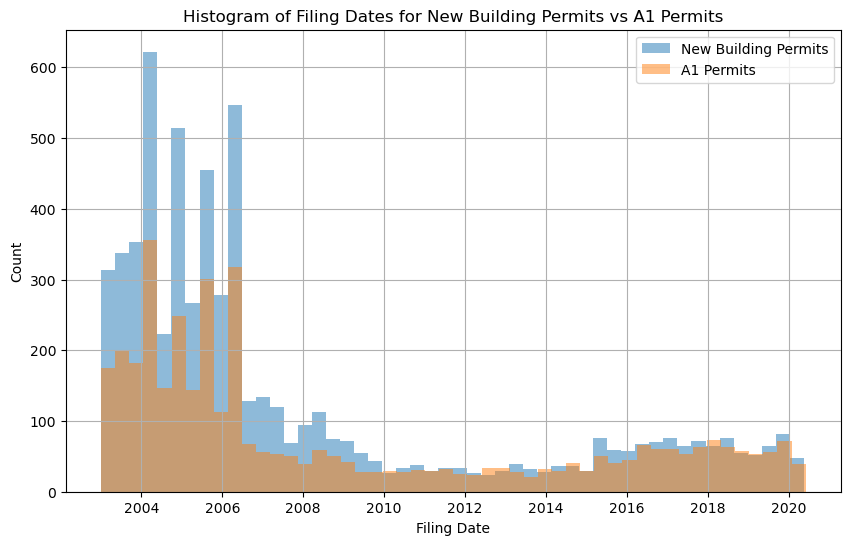

In [11]:
# Filter data for new building permits (NB) and A1 permits
nb_df = amc_df[amc_df['job_type'] == 'NB']
a1_df = amc_df[amc_df['job_type'] == 'A1']

# Create histograms
plt.figure(figsize=(10, 6))

# Histogram for new building permits
plt.hist(nb_df['filing_date'], bins=50, alpha=0.5, label='New Building Permits')

# Histogram for A1 permits
plt.hist(a1_df['filing_date'], bins=50, alpha=0.5, label='A1 Permits')

plt.xlabel('Filing Date')
plt.ylabel('Count')
plt.title('Histogram of Filing Dates for New Building Permits vs A1 Permits')
plt.legend()
plt.grid(True)
plt.show()

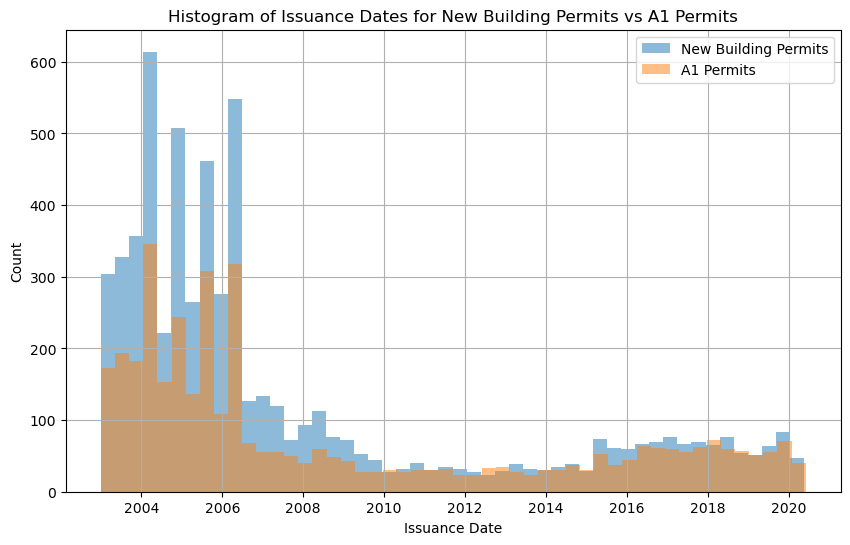

In [12]:
# Filter data for new building permits (NB) and A1 permits
nb_df = amc_df[amc_df['job_type'] == 'NB']
a1_df = amc_df[amc_df['job_type'] == 'A1']

# Create histograms
plt.figure(figsize=(10, 6))

# Histogram for new building permits
plt.hist(nb_df['issuance_date'], bins=50, alpha=0.5, label='New Building Permits')

# Histogram for A1 permits
plt.hist(a1_df['issuance_date'], bins=50, alpha=0.5, label='A1 Permits')

plt.xlabel('Issuance Date')
plt.ylabel('Count')
plt.title('Histogram of Issuance Dates for New Building Permits vs A1 Permits')
plt.legend()
plt.grid(True)
plt.show()

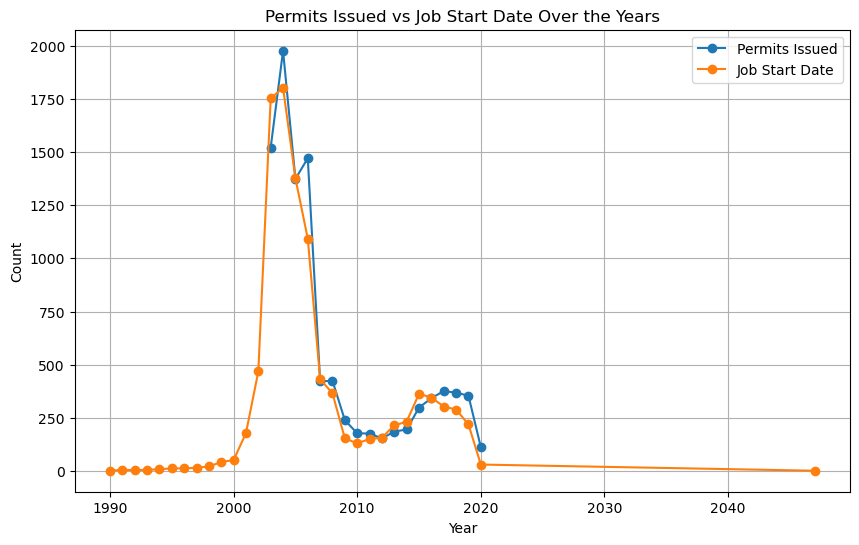

In [13]:
# Extract years for issuance_date and job_start_date
amc_df['issuance_year'] = amc_df['issuance_date'].dt.year
amc_df['job_start_year'] = amc_df['job_start_date'].dt.year

# Group and count permits by year
permits_issued_by_year = amc_df.groupby('issuance_year').size()
permits_filed_by_year = amc_df.groupby('job_start_year').size()

# Create a line chart
plt.figure(figsize=(10, 6))

plt.plot(permits_issued_by_year.index, permits_issued_by_year, marker='o', label='Permits Issued')
plt.plot(permits_filed_by_year.index, permits_filed_by_year, marker='o', label='Job Start Date')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Permits Issued vs Job Start Date Over the Years')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#Column distribution
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Validate inputs
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a DataFrame.")
    
    nunique = df.nunique()
    valid_columns = [col for col in df if 1 < nunique[col] < 50]
    nCol = len(valid_columns)
    
    # Calculate the number of rows in the subplot grid
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    
    # Create the subplot grid
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow))
    
    for i, col in enumerate(valid_columns[:nGraphShown]):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        column_data = df[col]
        
        if not np.issubdtype(type(column_data.iloc[0]), np.number):
            value_counts = column_data.value_counts()
            value_counts.plot.bar()
        else:
            column_data.hist()
        
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{col} Distribution')
    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

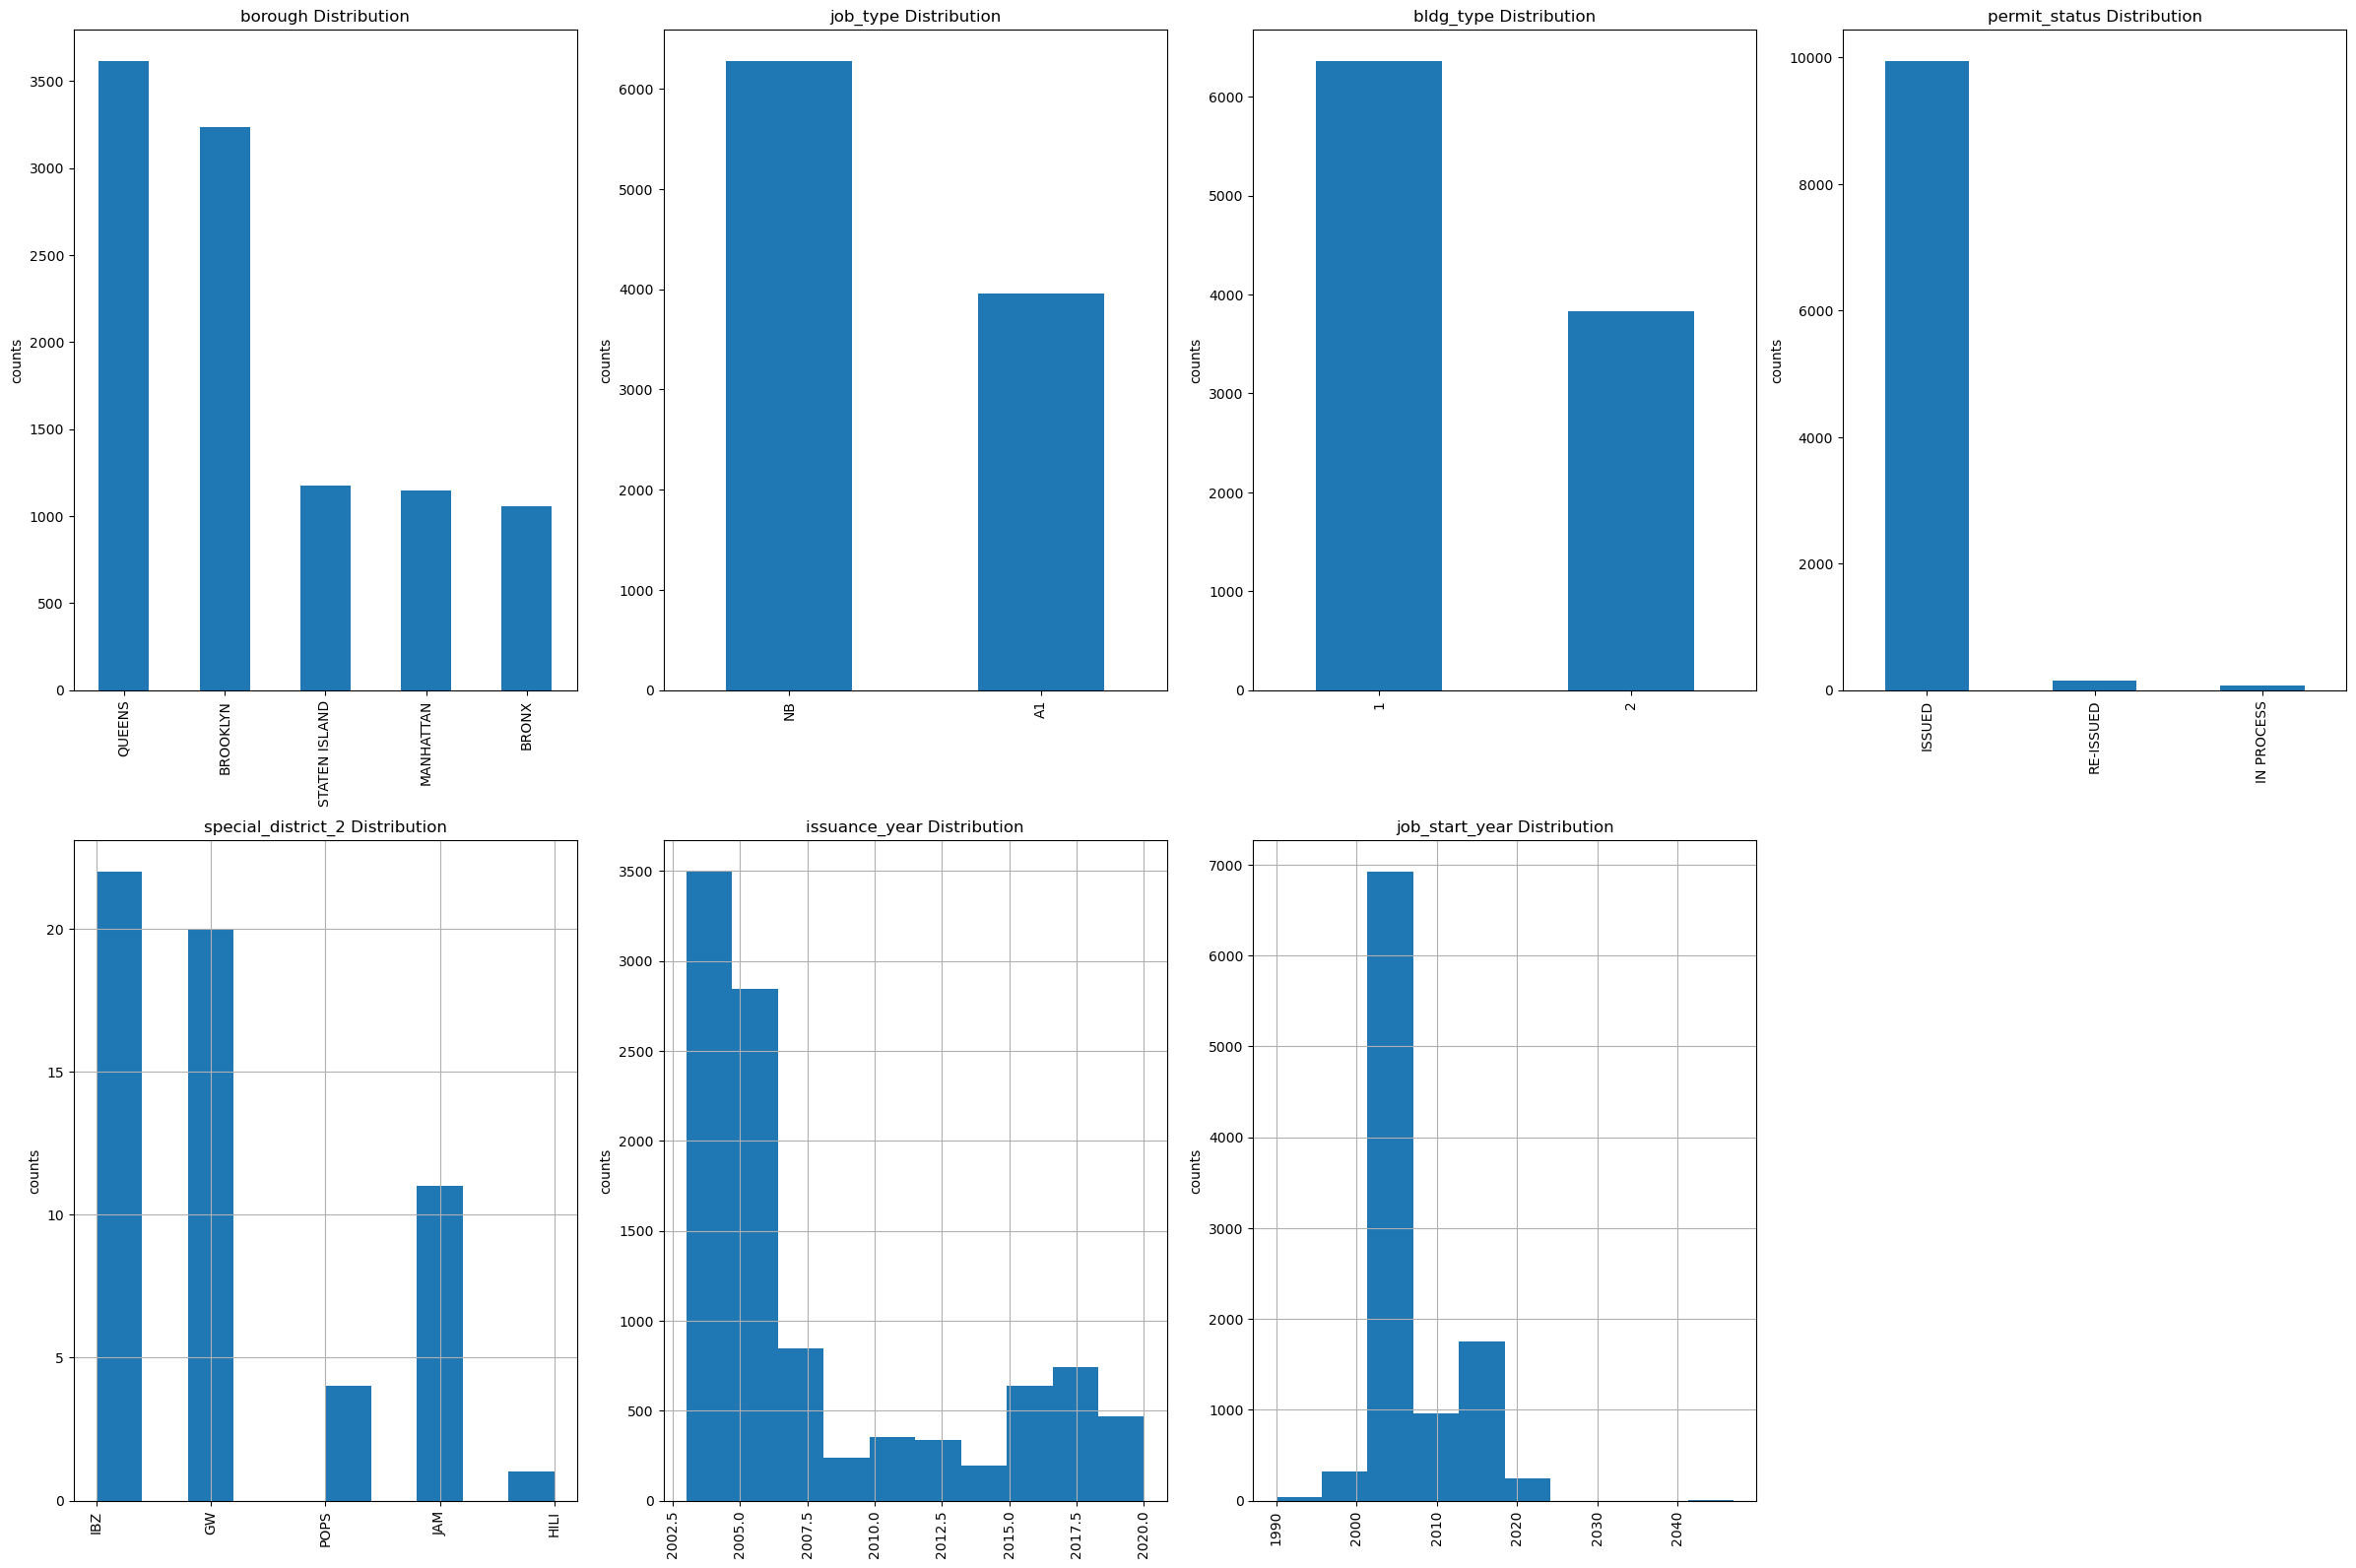

In [16]:
#Summary for column distribution
plotPerColumnDistribution(amc_df, 10, 4)

In [17]:
#convert pandas data frame into geodataframe
#convert latitude and longitude to Point geometries
geometry = [Point(xy) for xy in zip(amc_df['gis_longitude'], amc_df['gis_latitude'])]

#create a GeoDataFrame from the DataFrame
amc_gdf = gpd.GeoDataFrame(amc_df, geometry=geometry)

#display the GeoDataFrame
amc_gdf.head()

borough    bin__ house__       street_name      job__ job_type  block  \
0   BROOKLYN  3326326     171  STOCKHOLM STREET  301251160       A1  03246   
1      BRONX  2103856    1106     FOREST AVENUE  200783321       NB  02661   
2     QUEENS  4285898  182-06         145 DRIVE  401967056       A1  13347   
3  MANHATTAN  1086146      72  EAST  119 STREET  102968237       NB  01745   
4     QUEENS  4533174   86-07         51 AVENUE  401604616       NB  01836   

     lot zip_code bldg_type  ... gis_latitude gis_longitude gis_census_tract  \
0  00043    11237         2  ...    40.699710    -73.922595              429   
1  00008    10456         1  ...    40.827064    -73.902516              135   
2  00021    11413         1  ...    40.663320    -73.763662              320   
3  00142    10035         1  ...    40.801601    -73.942704              184   
4  00128    11373         2  ...    40.738665    -73.877252              471   

                           gis_nta_name  special_district_1  issuance_date  \
0                        Bushwick North                 NaN            NaT   
1                    Morrisania-Melrose                 NaN            NaT   
2  Springfield Gardens South-Brookville                 NaN            NaT   
3                     East Harlem North                 NaN            NaT   
4                              Elmhurst                 NaN            NaT   

  special_district_2 issuance_year job_start_year                    geometry  
0                NaN           NaN           2002  POINT (-73.92260 40.69971)  
1                NaN           NaN           2003  POINT (-73.90252 40.82706)  
2                NaN           NaN           2005  POINT (-73.76366 40.66332)  
3                NaN           NaN           2001  POINT (-73.94270 40.80160)  
4                NaN           NaN           2003  POINT (-73.87725 40.73866)  

[5 rows x 24 columns]

<AxesSubplot: >

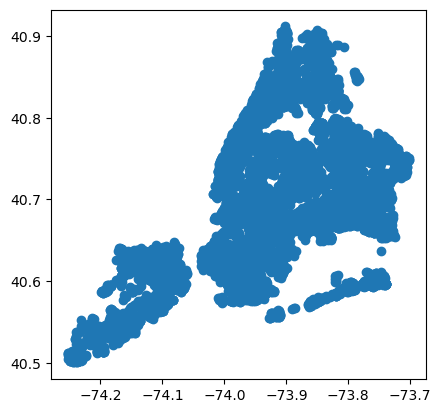

In [18]:
amc_gdf.crs = 'epsg:4326'
amc_gdf.plot()

In [19]:
#load nta data and map
ntaData = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

ERROR:fiona._env:PROJ: proj_create_from_database: C:\Users\georg\anaconda3\envs\wxy_geopy\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Users\georg\anaconda3\envs\wxy_geopy\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [20]:
ntaData.head()

OBJECTID  BoroCode  BoroName CountyFIPS NTA2020             NTAName  \
0         1         3  Brooklyn        047  BK0101          Greenpoint   
1         2         3  Brooklyn        047  BK0102        Williamsburg   
2         3         3  Brooklyn        047  BK0103  South Williamsburg   
3         4         3  Brooklyn        047  BK0104   East Williamsburg   
4         5         3  Brooklyn        047  BK0201    Brooklyn Heights   

   NTAAbbrev NTAType CDTA2020  \
0      Grnpt       0     BK01   
1   Wllmsbrg       0     BK01   
2  SWllmsbrg       0     BK01   
3  EWllmsbrg       0     BK01   
4      BkHts       0     BK02   

                                            CDTAName   Shape__Area  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  3.532114e+07   
1     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  2.885425e+07   
2     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  1.520896e+07   
3     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  5.226628e+07   
4  BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...  9.982387e+06   

   Shape__Length                                           geometry  
0   28912.525557  POLYGON ((-73.93214 40.72817, -73.93238 40.728...  
1   28097.891358  POLYGON ((-73.95814 40.72441, -73.95772 40.724...  
2   18250.280262  POLYGON ((-73.95024 40.70548, -73.94984 40.705...  
3   43184.732279  POLYGON ((-73.92406 40.71412, -73.92404 40.714...  
4   14312.482065  POLYGON ((-73.99237 40.68970, -73.99436 40.690...

In [21]:
ntaData.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

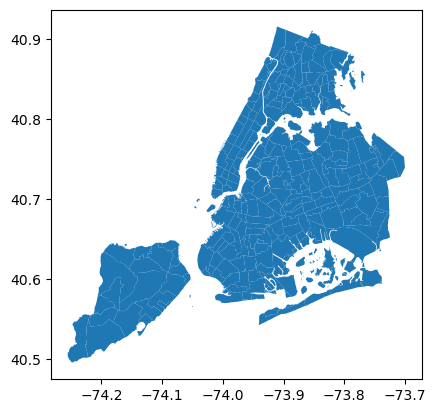

In [22]:
ntaData.plot()

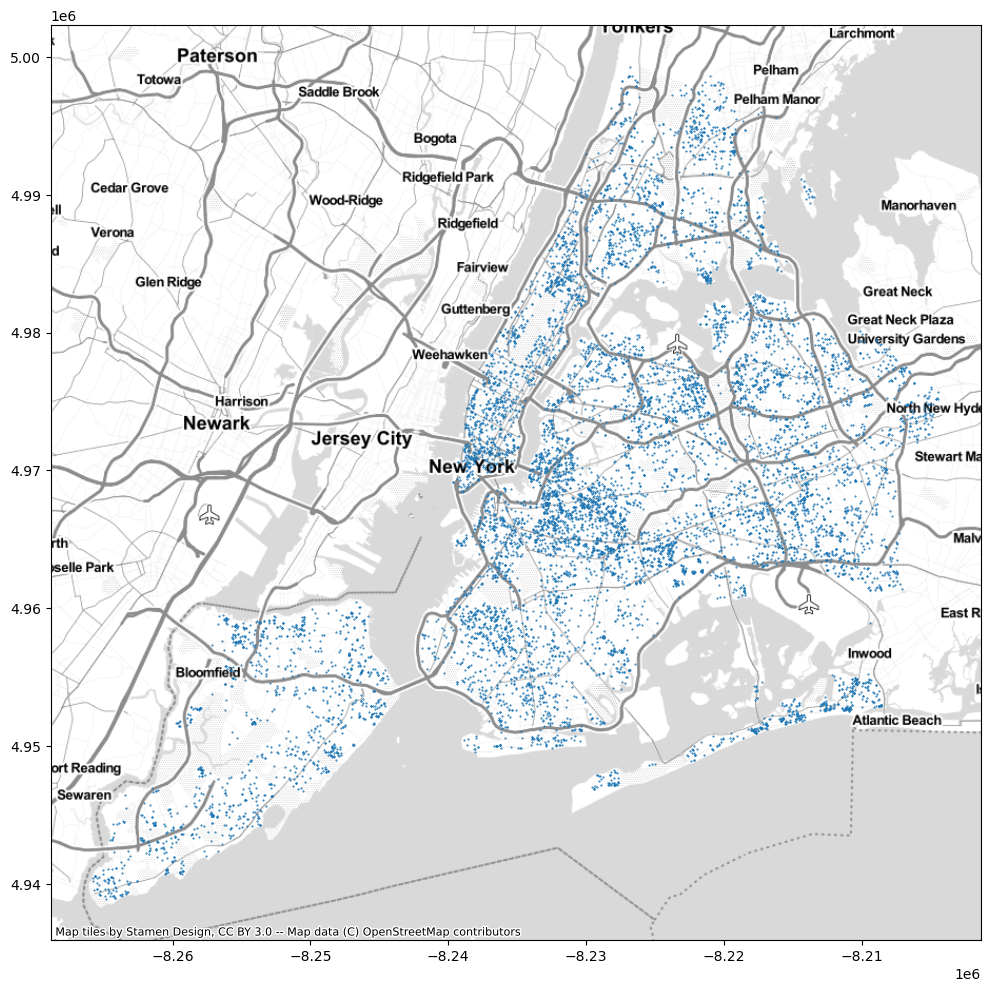

In [23]:
# Create a plot using GeoDataFrame geometry
amc_gdf = amc_gdf.to_crs(epsg=3857)
ax = amc_gdf.plot(figsize=(12,14), markersize=0.25)

# Add a basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()
ax.set_axis_off()

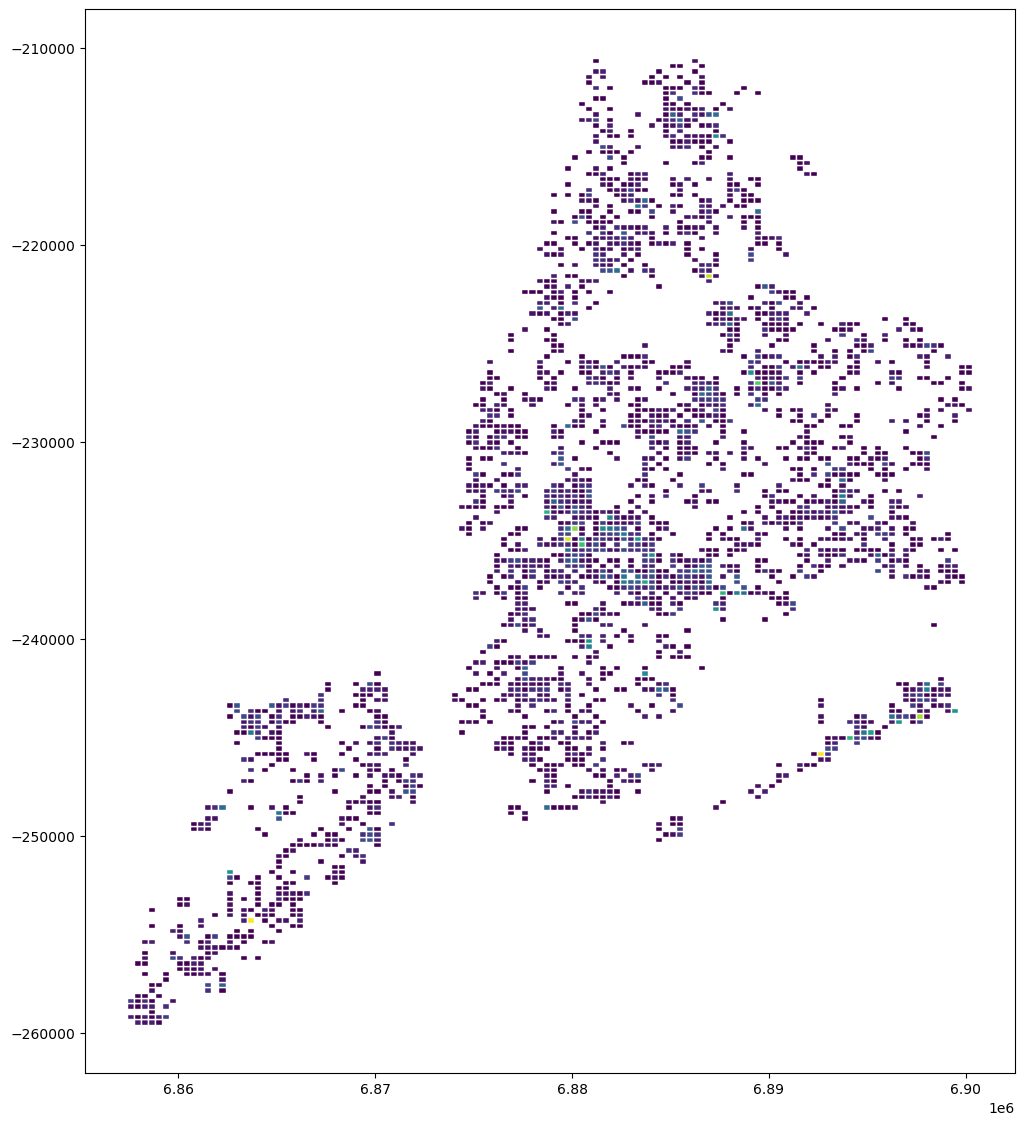

In [24]:

# filter the tree dataset to only those within Manhattan
amc_nbd = amc_gdf.loc[amc_gdf['job_type']=='NB']

amc_nbd = amc_nbd.to_crs('EPSG:3587')

# get the outer bounds of the points
xmin, ymin, xmax, ymax = amc_nbd.total_bounds

# specify the number of cells along x + y axis
x = 120
y = 180
wide = abs(xmin - xmax)/x
length = abs(ymin - ymax)/y

# create a list of points that will define grid corners
cols = np.arange(xmin, xmax + wide, wide)
rows = np.arange(ymin, ymax + length, length)

# iterate over list of corners to create Shapely Polygon objects
polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons, 'cell_id': list(range(len(polygons)))})
grid.crs = 'EPSG:3587'

# merge the two datasets
grid_nb = gpd.sjoin(grid, amc_nbd)

# count the number of trees in each cell
grid_nbc = grid_nb.groupby('cell_id')['job__'].count()

# rename the column for convenience
grid_nbc.rename('nb_count', inplace=True)

# merge the two tree counts with the grid GeoDataFrame and plot
grid.merge(grid_nbc, on='cell_id').plot(
  column='nb_count', figsize=(12,14), edgecolor='white')

# Add a basemap using contextily
#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()

In [25]:

# Drop rows with NaT values in specified date columns
date_columns = ['issuance_date', 'job_start_date', 'filing_date']  
amc_gdfc = amc_gdf.dropna(subset=date_columns, how='any')

In [26]:
# Load an empty map
from keplergl import KeplerGl
amcMap = KeplerGl()
amcMap.add_data(data=amc_gdfc, name='DOB Permits')
amcMap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\georg\anaconda3\envs\wxy_geopy\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'DOB Permits': {'index': [8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,…

In [119]:
# Reproject amc_gdfc to match the CRS of ntaData
amc_gdfcr = amc_gdfc.to_crs(ntaData.crs)

amc_ntagdf = gpd.sjoin(amc_gdfcr, ntaData, how='left')
print(amc_ntagdf.columns)

Index(['borough', 'bin__', 'house__', 'street_name', 'job__', 'job_type',
       'block', 'lot', 'zip_code', 'bldg_type', 'permit_status', 'filing_date',
       'job_start_date', 'permit_si_no', 'gis_latitude', 'gis_longitude',
       'gis_census_tract', 'gis_nta_name', 'special_district_1',
       'issuance_date', 'special_district_2', 'issuance_year',
       'job_start_year', 'geometry', 'index_right', 'OBJECTID', 'BoroCode',
       'BoroName', 'CountyFIPS', 'NTA2020', 'NTAName', 'NTAAbbrev', 'NTAType',
       'CDTA2020', 'CDTAName', 'Shape__Area', 'Shape__Length'],
      dtype='object')


In [130]:
unique_count = amc_ntagdf['job__'].nunique()
print("Number of unique values:", unique_count)
clean_amcgdf = amc_ntagdf[~amc_ntagdf['job__'].duplicated()]
print("Original DataFrame shape:", amc_ntagdf.shape)
print("Cleaned DataFrame shape:", clean_amcgdf.shape)

Number of unique values: 9471
Original DataFrame shape: (10164, 37)
Cleaned DataFrame shape: (9471, 37)


In [137]:
# Group by 'gis_nta_name' and calculate the sum of 'NB' and 'A1' permits using conditional aggregation
nta_permit_sum = clean_amcgdf.groupby('NTAName')['job_type'].apply(lambda x: (x == 'NB').sum()).reset_index(name='NB').merge(
    clean_amcgdf.groupby('NTAName')['job_type'].apply(lambda x: (x == 'A1').sum()).reset_index(name='A1'),
    on='NTAName'
)

# Convert 'NB' and 'A1' columns to numeric (if they're not already)
nta_permit_sum['NB'] = pd.to_numeric(nta_permit_sum['NB'], errors='coerce')
nta_permit_sum['A1'] = pd.to_numeric(nta_permit_sum['A1'], errors='coerce')

# Fill NaN values with 0
nta_permit_sum.fillna(0, inplace=True)

# Print the resulting DataFrame
print(nta_permit_sum)

                                    NTAName   NB  A1
0                                  Allerton    3   3
1    Annadale-Huguenot-Prince's Bay-Woodrow  142  15
2                   Arden Heights-Rossville   36   6
3                         Astoria (Central)   32  17
4           Astoria (East)-Woodside (North)   18  23
..                                      ...  ...  ..
202                            Williamsburg   79  39
203             Windsor Terrace-South Slope   16  10
204                               Woodhaven   20  13
205                       Woodlawn Cemetery    1   0
206                                Woodside   34  17

[207 rows x 3 columns]


In [142]:
clean_amcgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9471 entries, 8 to 10229
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   borough             9471 non-null   object        
 1   bin__               9471 non-null   object        
 2   house__             9471 non-null   object        
 3   street_name         9471 non-null   object        
 4   job__               9471 non-null   object        
 5   job_type            9471 non-null   object        
 6   block               9471 non-null   object        
 7   lot                 9471 non-null   object        
 8   zip_code            9471 non-null   object        
 9   bldg_type           9471 non-null   object        
 10  permit_status       9471 non-null   object        
 11  filing_date         9471 non-null   datetime64[ns]
 12  job_start_date      9471 non-null   datetime64[ns]
 13  permit_si_no        9471 non-null   obj

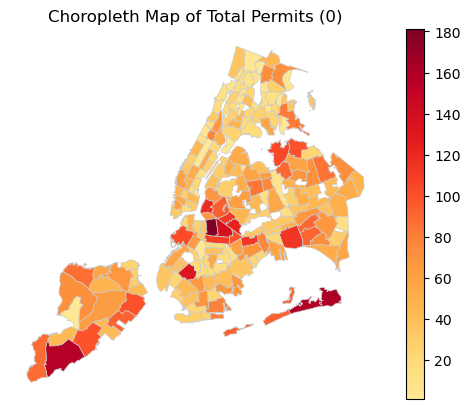

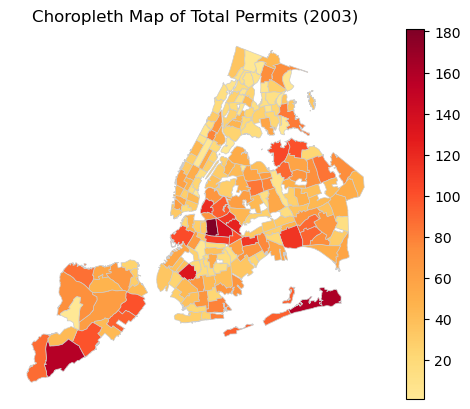

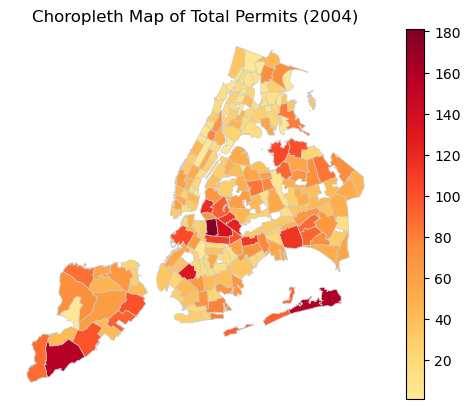

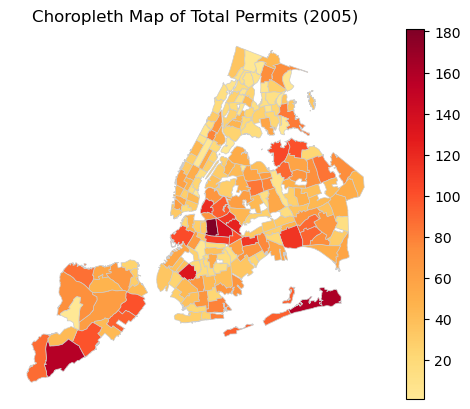

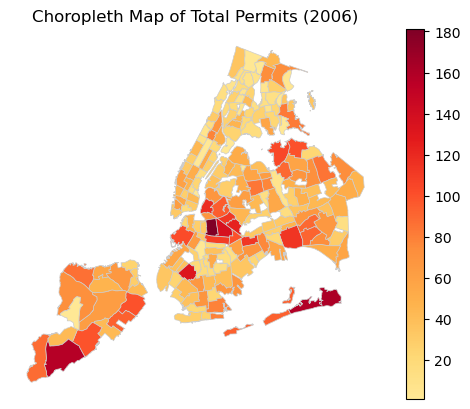

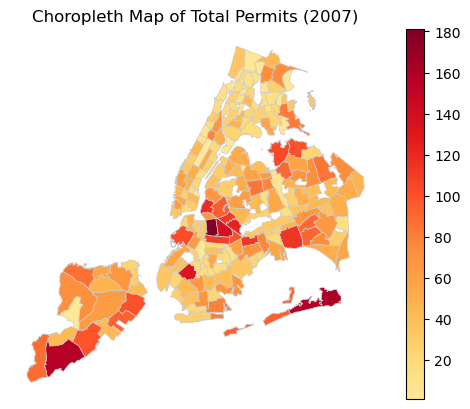

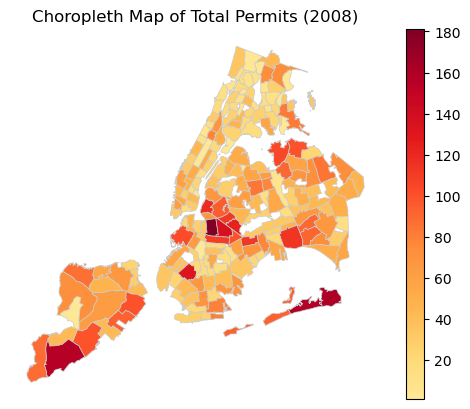

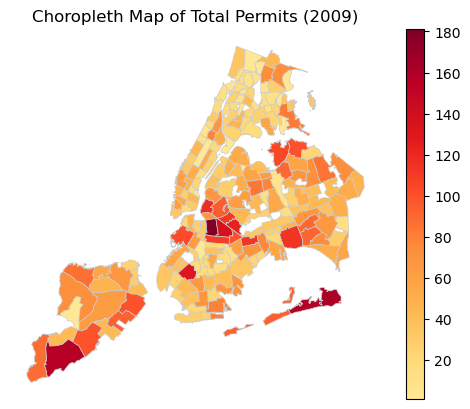

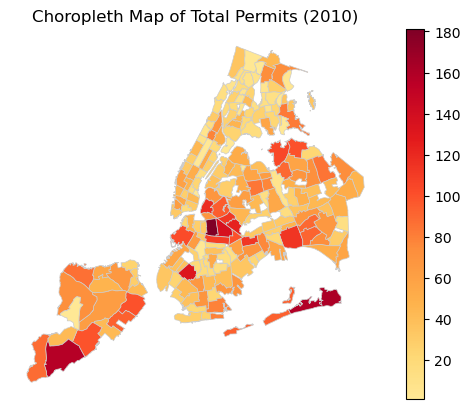

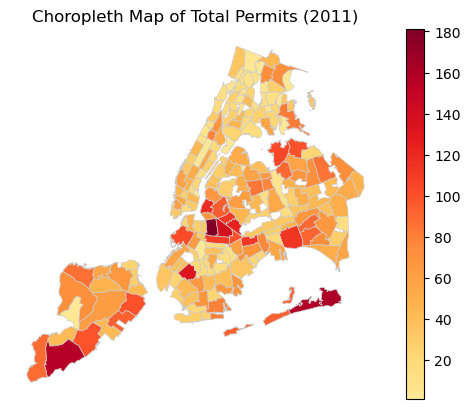

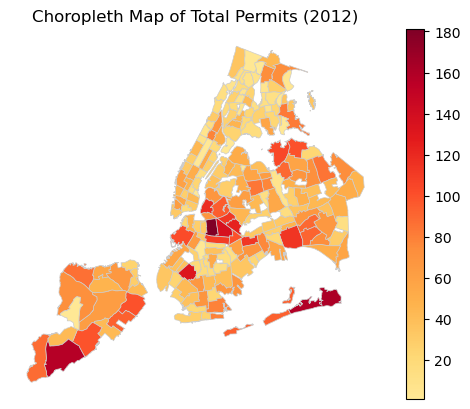

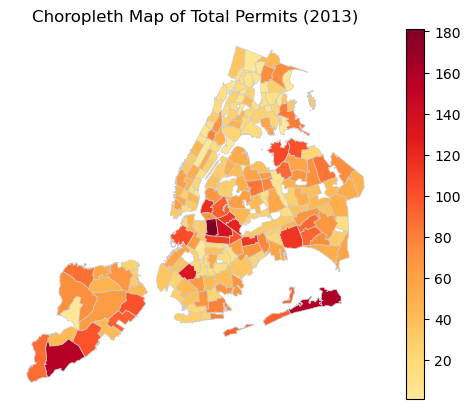

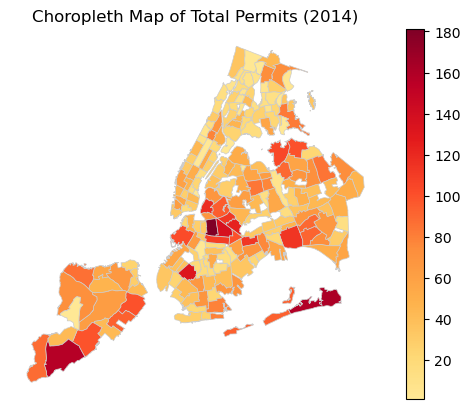

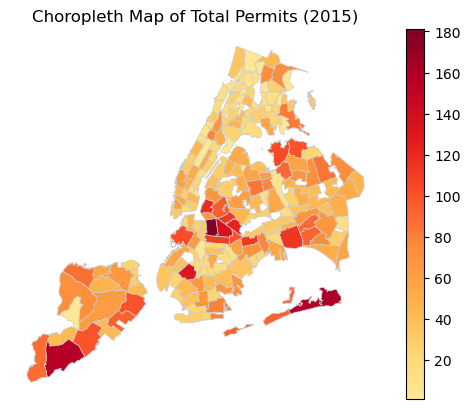

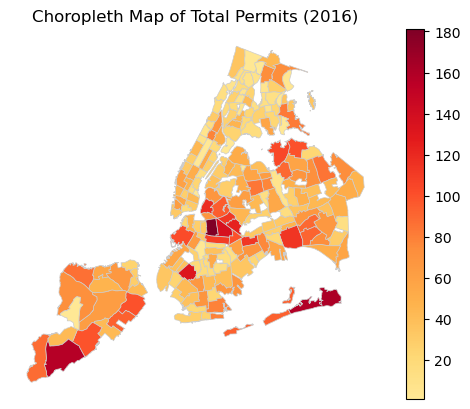

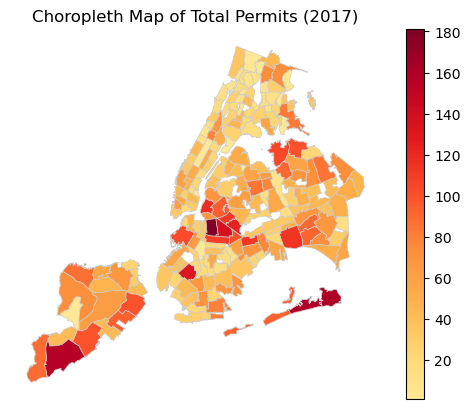

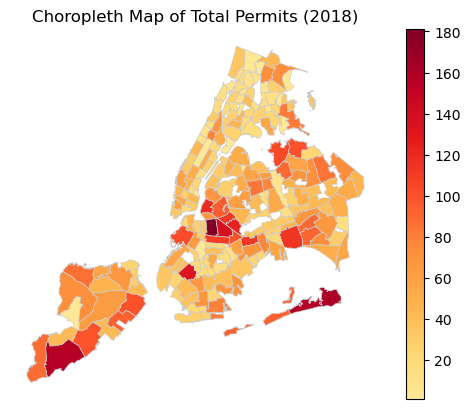

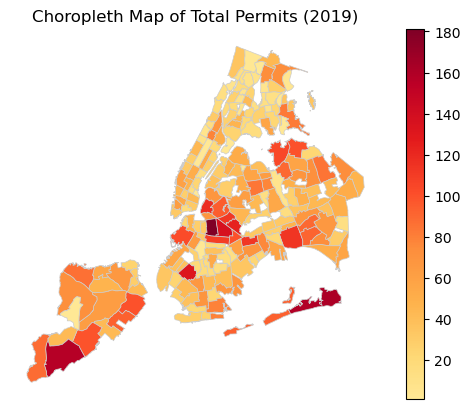

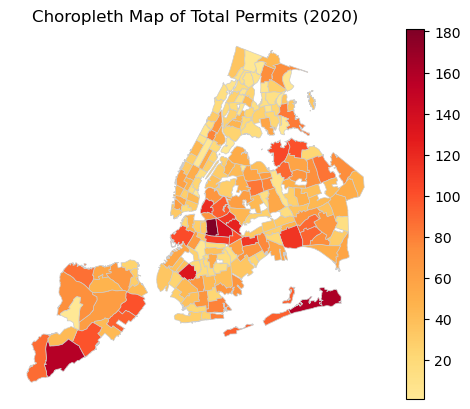

In [146]:
import matplotlib.colors as mcolors

# Create a custom color map without white color
colors = plt.cm.YlOrRd(np.linspace(0, 1, 256))
colors = colors[40:]  # Exclude white and lighter colors
custom_cmap = mcolors.ListedColormap(colors)

# Convert 'issuance_year' to integer after handling non-finite values
amcNta_gdfc['issuance_year'] = amcNta_gdfc['issuance_year'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

# Sort unique issuance years in chronological order
unique_years = sorted(amcNta_gdfc['issuance_year'].unique())

# Plot a choropleth map for each year
for year in unique_years:
    subset = nta_permit_gdf.copy()
    
    # Merge with permit counts for the specific year
    year_counts = clean_amcgdf[clean_amcgdf['issuance_year'] == year].groupby('NTAName')['job_type'].count().reset_index(name='total_permit_count')
    subset = subset.merge(year_counts, on='NTAName', how='left')
    
    # Fill NaN values with 0
    subset.fillna(0, inplace=True)
    
    # Calculate the total permit count (sum of NB and A1)
    subset['total_permit_sum'] = subset['NB'] + subset['A1']
    
    # Create a choropleth map with custom color map
    ax = subset.plot(column='total_permit_sum', cmap=custom_cmap, linewidth=0.5, edgecolor='0.8', legend=True)

    # Set plot title and remove axes
    ax.set_title(f'Choropleth Map of Total Permits ({year})')
    ax.set_axis_off()

    # Show the plot
    plt.show()


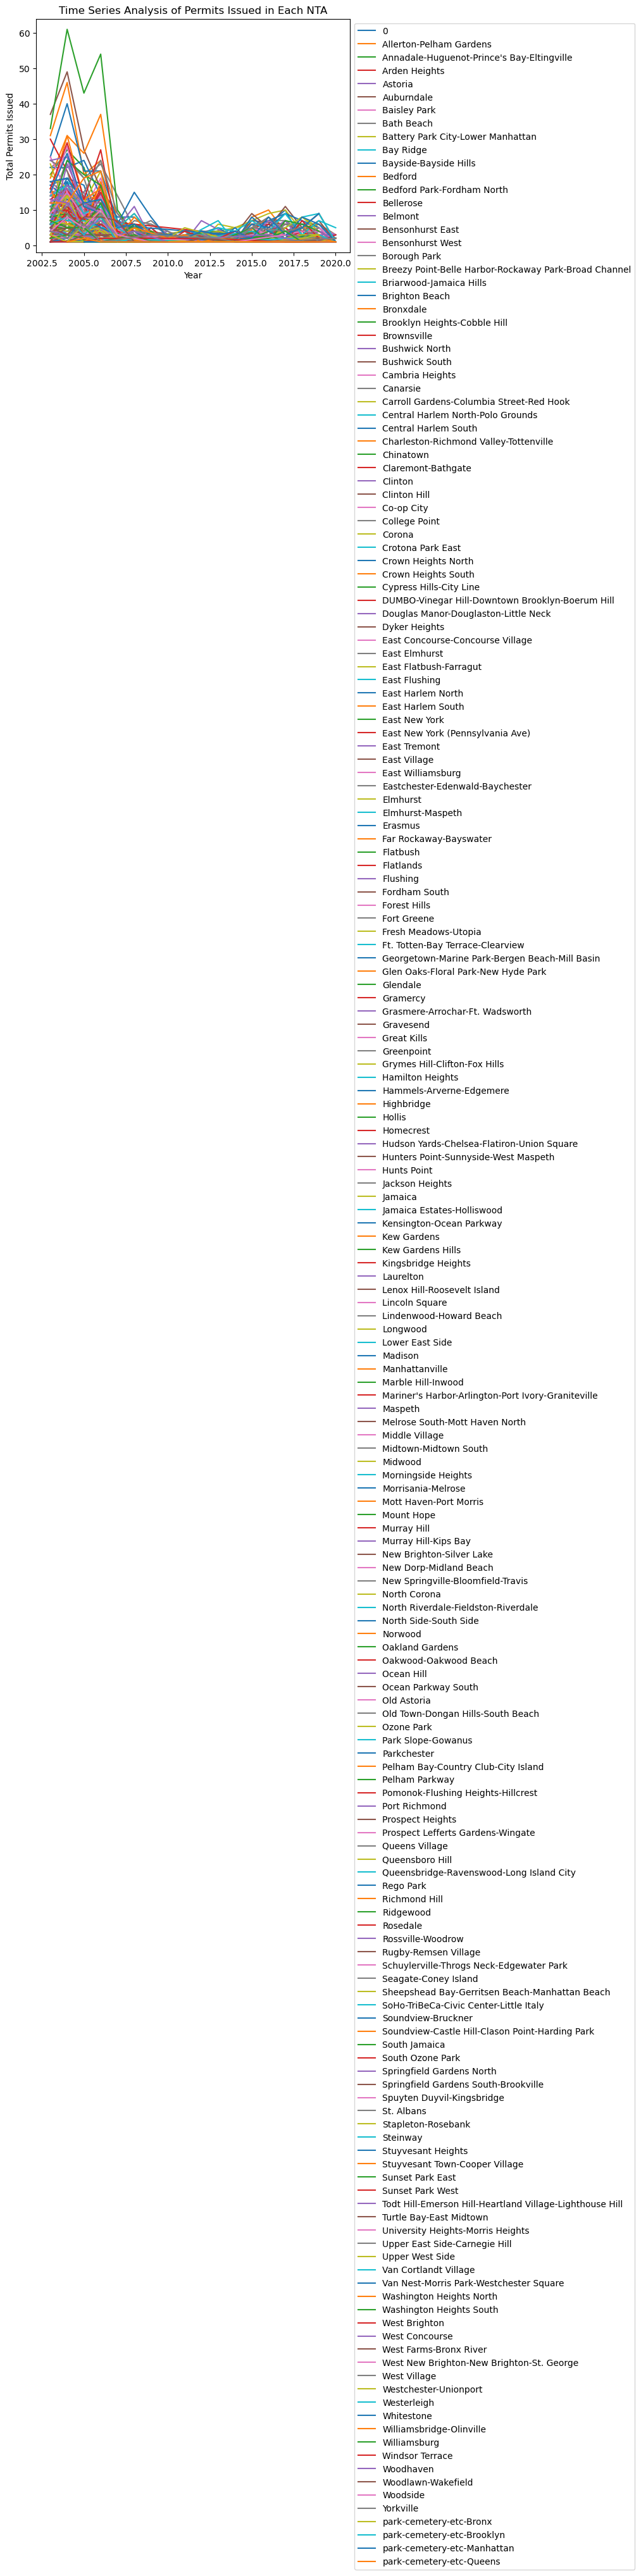

<Figure size 640x480 with 0 Axes>

In [159]:

# Group the DataFrame by NTA and issuance_year, and calculate the total permits count
nta_yearly_counts = clean_amcgdf.groupby(['gis_nta_name', 'issuance_year'])['job_type'].count().reset_index(name='total_permits')

# Get a list of unique NTAs
unique_ntas = nta_yearly_counts['gis_nta_name'].unique()

# Plot a line chart for each NTA
for nta in unique_ntas:
    nta_data = nta_yearly_counts[nta_yearly_counts['gis_nta_name'] == nta]
    plt.plot(nta_data['issuance_year'], nta_data['total_permits'], label=nta)

# Set plot title, labels, and legend
plt.title('Time Series Analysis of Permits Issued in Each NTA')
plt.xlabel('Year')
plt.ylabel('Total Permits Issued')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

output_path = r'C:\Users\georg\OneDrive\Documents\GitHub\python-notebooks\images'
plt.savefig(output_path)

In [150]:
import pandas as pd
import numpy as np

# Group the DataFrame by NTA and issuance_year, and calculate the total permits count
nta_yearly_counts = clean_amcgdf.groupby(['gis_nta_name', 'issuance_year'])['job_type'].count().reset_index(name='total_permits')

# Pivot the data to have each NTA as a column and issuance_year as the index
pivot_table = nta_yearly_counts.pivot_table(index='issuance_year', columns='gis_nta_name', values='total_permits', fill_value=0)

# Calculate the correlation matrix
correlation_matrix = pivot_table.corr()

# Show the correlation matrix
print(correlation_matrix)


gis_nta_name                                       0  Allerton-Pelham Gardens  \
gis_nta_name                                                                    
0                                           1.000000                 0.078029   
Allerton-Pelham Gardens                     0.078029                 1.000000   
Annadale-Huguenot-Prince's Bay-Eltingville  0.201819                 0.923531   
Arden Heights                               0.168787                 0.790828   
Astoria                                     0.163417                 0.821578   
...                                              ...                      ...   
Yorkville                                   0.130680                 0.536625   
park-cemetery-etc-Bronx                     0.100470                 0.458609   
park-cemetery-etc-Brooklyn                  0.166261                 0.551000   
park-cemetery-etc-Manhattan                -0.039091                 0.111083   
park-cemetery-etc-Queens    

In [ ]:
# Export GeoDataFrame to Shapefile
output_shapefile_path = 'path/to/your/folder/geodataframe.xlsx'
clean_amcntagdf.to_file(output_shapefile_path)

# Export GeoDataFrame to Shapefile
output_shapefile_path = 'path/to/your/folder/geodataframe.shp'
clean_amcntagdf_gdf.to_file(output_shapefile_path)